<a href="https://colab.research.google.com/github/quanghuydsai/Project-III/blob/main/LDMOL_ENCODING_WITH_RANK_LOSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers pathlib rdkit

In [2]:
from google.colab import drive
from google.colab import files

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import torch
import re
class regexTokenizer():
    def __init__(self,vocab_path='/content/drive/MyDrive/LDMol/vocab_bpe_300_sc.txt',max_len=127):
        with open(vocab_path,'r') as f:
            x = f.readlines()
            x = [xx.replace('##', '') for xx in x]
            x2 = x.copy()
        x2.sort(key=len, reverse=True)
        pattern = "("+"|".join(re.escape(token).strip()[:-1] for token in x2)+")"
        self.rg = re.compile(pattern)

        self.idtotok  = { cnt:i.strip() for cnt,i in enumerate(x)}
        self.vocab_size = len(self.idtotok) #SOS, EOS, pad
        self.toktoid = { v:k for k,v in self.idtotok.items()}
        self.max_len = max_len
        self.cls_token_id = self.toktoid['[CLS]']
        self.sep_token_id = self.toktoid['[SEP]']
        self.pad_token_id = self.toktoid['[PAD]']

    def decode_one(self, iter):
        if self.sep_token_id in iter:   iter = iter[:(iter == self.sep_token_id).nonzero(as_tuple=True)[0][0].item()]
        # return "".join([self.ind2Letter(i) for i in iter]).replace('[SOS]','').replace('[EOS]','').replace('[PAD]','')
        return "".join([self.idtotok[i.item()] for i in iter[1:]])

    def decode(self,ids:torch.tensor):
        if len(ids.shape)==1:
            return [self.decode_one(ids)]
        else:
            smiles  = []
            for i in ids:
                smiles.append(self.decode_one(i))
            return smiles
    def __len__(self):
        return self.vocab_size

    def __call__(self,smis:list, truncation='max_len'):
        tensors = []
        lengths = []
        if type(smis) is str:
            smis = [smis]
        for i in smis:
            length, tensor = self.encode_one(i)
            tensors.append(tensor)
            lengths.append(length)
        output = torch.concat(tensors,dim=0)
        if truncation == 'max_len':
            return output
        elif truncation == 'longest':
            return output[:, :max(lengths)]
        else:
            raise ValueError('truncation should be either max_len or longest')

    def encode_one(self, smi):
        smi = '[CLS]' + smi + '[SEP]'
        res = [self.toktoid[i] for i in self.rg.findall(smi)]
        token_length = len(res)
        if token_length < self.max_len:
            res += [self.pad_token_id]*(self.max_len-len(res))
        else:
            res = res[:self.max_len]
            # res[-1] = self.sep_token_id
        return token_length, torch.LongTensor([res])

In [4]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [5]:
from abc import abstractmethod
from random import shuffle
from typing import Any
from typing import Iterable
from typing import List
from typing import Union

import numpy as np
from rdkit import Chem

In [6]:
Mol = Chem.Mol
class Augmenter:
    """An abstract base class for molecular augmenters.

    The class has one method, `augment`, which is overriden by child classes.
    It is possible to call the class with either a list of molecules or a single
    molecules. This input will then be passed to `augment` and the augmented
    molecule(s) will be returned.
    The Boolean ".active" property can be set to toggle augmentation.

    :param active: Whether the augmentation should be active or not, defaults to True.
    :param augment_prob: if lower than 1, it is used to randomly turn-off augmentation on an individual basis
    """

    def __init__(self, active: bool = True, augment_prob: float = 1.0) -> None:
        self.active = active
        self.augment_prob = augment_prob

    def __call__(self, data: Union[Iterable[Any], Any]) -> List[Any]:
        """Augments either a list of Anys or a single molecule by making sure
        the input is put into a `List` and then passed to the `augment` function.

        :param data: Either a list of molecules or a single molecules to be augmented.

        :return: A list of augmented molecules.
        """
        # Str is Iterable but must be encapsulated (e.g. single SMILES string)
        if not isinstance(data, Iterable) or isinstance(data, str):
            data = [data]

        return self.augment(data)

    @abstractmethod
    def _augment(self, data: Iterable[Any]) -> List[Any]:
        raise NotImplementedError()

    def augment(self, data: Iterable[Any]) -> List[Any]:
        """
        Augment a given list

        :param data: a list of molecules to be augmented.
        :return: A list of augmented molecules.
        """
        if self.active:
            return self._augment(data)
        return list(data)
class MolAugmenter(Augmenter):
    """
    Augmenter that works on RDKit Mol objects
    """

    def randomize_mols_restricted(self, mols: Iterable[Mol]) -> List[Mol]:
        """Randomizes the atom ordering of a list of RDKit molecules (`rdkit.Chem.Mol`:s).

        :param mols: List of RDKit molecules to be augmented.
        :return:  List of augmented RDKit molecules.
        """
        return list(map(self.randomize_mol_restricted, mols))

    def randomize_mol_restricted(self, mol: Mol) -> Mol:
        """Randomize the atom ordering of a RDKit molecule (`rdkit.Chem.Mol`).

        :param mol:  RDKit molecule to get a randomized atom order.
        :return: RDKit molecule object with a randomized atom-order.
        """
        # Standard shuffle surprisingly leads to 35% slower code.
        if self.augment_prob < np.random.rand():
            return mol
        atom_order: List[int] = list(range(mol.GetNumAtoms()))
        np.random.shuffle(atom_order)
        return Chem.RenumberAtoms(mol, atom_order)

    def _augment(self, data: Iterable[Mol]) -> List[Mol]:
        """Randomizes `RDKit molecules by shuffling the atom order.

        :param data: List of RDKit molecules to be randomized.
        :return:  A list of randomized molecules.
        """
        return self.randomize_mols_restricted(data)

In [7]:
from torch.utils.data import Dataset
import random
from rdkit import Chem, RDLogger
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers

In [8]:
class SMILESDataset_pretrain(Dataset):
    def __init__(self, data_list, data_length=None, shuffle=False, is_train=True):
        """
        Args:
            data_list: Danh sách chứa các dict (ldmol_dataset)
            data_length: List [start, end] để cắt dữ liệu nếu cần
            shuffle: Trộn dữ liệu
            is_train: Chế độ huấn luyện hay đánh giá
        """
        # Cắt dữ liệu theo data_length nếu có yêu cầu
        if data_length is not None:
            self.data = data_list[data_length[0] : data_length[1]]
        else:
            self.data = data_list

        if shuffle:
            random.shuffle(self.data)

        self.train = is_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Lấy SMILES từ dictionary 'smiles'
        smiles = self.data[index]['smiles']
        smiles2 = smiles

        # Logic tạo đồng phân lập thể (Stereoisomers)
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                # Tạo danh sách các đồng phân lập thể
                sc_list = list(EnumerateStereoisomers(mol))

                if self.train and len(sc_list) > 1:
                    # Lấy 2 đồng phân khác nhau cho Contrastive Learning
                    mol_a, mol_b = random.sample(sc_list, k=2)
                    smiles = Chem.MolToSmiles(mol_a, canonical=True, isomericSmiles=True)
                    smiles2 = Chem.MolToSmiles(mol_b, canonical=True, isomericSmiles=True)
                else:
                    # Lấy ngẫu nhiên 1 đồng phân
                    mol_selected = random.choice(sc_list)
                    smiles = Chem.MolToSmiles(mol_selected, canonical=True, isomericSmiles=True)
                    smiles2 = smiles
        except Exception as e:
            # Nếu lỗi RDKit, giữ nguyên smiles ban đầu
            pass

        # Trả về định dạng chuỗi để tokenizer xử lý (kết hợp bằng ký tự 'Q' như code gốc của bạn)
        if self.train and smiles2 != smiles:
            return f"[CLS]{smiles}Q[CLS]{smiles2}"

        return f"[CLS]{smiles}"

In [9]:
from transformers.models.bert.configuration_bert import BertConfig

In [10]:
!pip install tqdm torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.7 MB/s eta 0:00:00


In [11]:
from torch_geometric.data import InMemoryDataset
class PubChemDataset(InMemoryDataset):
    def __init__(self, path):
        super(PubChemDataset, self).__init__()
        self.data, self.slices = torch.load(path, weights_only=False)

    def __getitem__(self, idx):
        return self.get(idx)

In [12]:
raw_dataset = PubChemDataset('/content/drive/MyDrive/LDMol/train.pt')

In [13]:
ldmol_dataset = []
for data in raw_dataset:
    ldmol_dataset.append({
            'smiles': data.smiles,
            'text': data.text
        })

In [14]:
print(ldmol_dataset[0:2])

[{'smiles': 'C1=CC=C(C=C1)C(CN)O', 'text': 'The molecule is the simplest member of the class of phenylethanolamines that is 2-aminoethanol bearing a phenyl substituent at the 1-position. The parent of the phenylethanolamine class. It has a role as a human metabolite. It is a conjugate base of a phenylethanolaminium.\nThe molecule is a natural product found in Peucedanum palustre, Pseudo-nitzschia multistriata, and other organisms with data available.\nThe molecule is also used in chemical industry.'}, {'smiles': 'CC(=C)C(CC1=C2C(=C(C3=C1OC4=C(C3=O)C=C(C=C4)O)O)C=CC(O2)(C)C)OO', 'text': 'The molecule is a member of the class of pyranoxanthones that is 2H,6H-pyrano[3,2-b]xanthen-6-one substituted by a 2-hydroperoxy-3-methylbut-3-en-1-yl moiety at position 12, hydroxy groups at positions 5 and 8 and geminal methyl groups at position 2. It is isolated from the stem bark of Calophyllum brasiliense and exhibits significant inhibitory activity against 12-O-tetradecanoylphorbol-13-acetate indu

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import BertModel
from rdkit import Chem
import tqdm

In [16]:
BERT_CONFIG_DICT = {
    "attention_probs_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 1024,
    "initializer_range": 0.02,
    "intermediate_size": 3072,
    "layer_norm_eps": 1e-12,
    "max_position_embeddings": 512,
    "model_type": "bert",
    "num_attention_heads": 16,
    "num_hidden_layers": 12,
    "pad_token_id": 0,
    "type_vocab_size": 2,
    "vocab_size": 300
}

In [17]:
class ListDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [18]:
TRAIN_CONFIG = {
    'embed_dim': 256,
    'batch_size': 32, # Giảm xuống nếu bị tràn bộ nhớ GPU trên Colab
    'temp': 0.2,
    'queue_size': 8192,
    'momentum': 0.995,
    'alpha': 0.1,
    'lr': 5e-5,
    'weight_decay': 0.02,
    'epochs': 10,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [19]:
class LDMolEncoder(nn.Module):
    def __init__(self, config, bert_config_dict):
        super().__init__()
        self.config = config

        # Khởi tạo BertConfig từ dict
        bert_config = BertConfig(**bert_config_dict)
        self.text_encoder = BertModel(config=bert_config)

        text_width = self.text_encoder.config.hidden_size
        self.text_proj = nn.Linear(text_width, config['embed_dim'])
        self.aug = MolAugmenter()

        # Momentum Models
        self.text_encoder_m = BertModel(config=bert_config)
        self.text_proj_m = nn.Linear(text_width, config['embed_dim'])

        # Đóng băng gradient cho momentum models
        for p in self.text_encoder_m.parameters(): p.requires_grad = False
        for p in self.text_proj_m.parameters(): p.requires_grad = False

        self.copy_params()

        # Contrastive Queue
        self.temp = nn.Parameter(torch.ones([]) * config['temp'])
        self.register_buffer("text1_queue", torch.randn(config['embed_dim'], config['queue_size']))
        self.register_buffer("text2_queue", torch.randn(config['embed_dim'], config['queue_size']))
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

        self.text1_queue = F.normalize(self.text1_queue, dim=0)
        self.text2_queue = F.normalize(self.text2_queue, dim=0)

    @torch.no_grad()
    def copy_params(self):
        for p, p_m in zip(self.text_encoder.parameters(), self.text_encoder_m.parameters()):
            p_m.data.copy_(p.data)
        for p, p_m in zip(self.text_proj.parameters(), self.text_proj_m.parameters()):
            p_m.data.copy_(p.data)

    @torch.no_grad()
    def _momentum_update(self):
        m = self.config['momentum']
        for p, p_m in zip(self.text_encoder.parameters(), self.text_encoder_m.parameters()):
            p_m.data = p_m.data * m + p.data * (1. - m)
        for p, p_m in zip(self.text_proj.parameters(), self.text_proj_m.parameters()):
            p_m.data = p_m.data * m + p.data * (1. - m)

    def forward(self, ids1, mask1, ids2, mask2, alpha=0):
        # Cập nhật momentum model
        self._momentum_update()

        # Trích xuất đặc trưng hiện tại
        out1 = self.text_encoder(ids1, attention_mask=mask1).last_hidden_state[:, 0, :]
        feat1 = F.normalize(self.text_proj(out1), dim=-1)

        out2 = self.text_encoder(ids2, attention_mask=mask2).last_hidden_state[:, 0, :]
        feat2 = F.normalize(self.text_proj(out2), dim=-1)

        with torch.no_grad():
            self.temp.clamp_(0.07, 0.5)

            # Momentum features
            m_out1 = self.text_encoder_m(ids1, attention_mask=mask1).last_hidden_state[:, 0, :]
            feat1_m = F.normalize(self.text_proj_m(m_out1), dim=-1)
            feat1_all = torch.cat([feat1_m.t(), self.text1_queue.clone().detach()], dim=1)

            m_out2 = self.text_encoder_m(ids2, attention_mask=mask2).last_hidden_state[:, 0, :]
            feat2_m = F.normalize(self.text_proj_m(m_out2), dim=-1)
            feat2_all = torch.cat([feat2_m.t(), self.text2_queue.clone().detach()], dim=1)

            # Targets
            batch_size = feat1.size(0)
            # Tạo ma trận mục tiêu: [batch_size, batch_size + queue_size]
            sim_targets = torch.zeros(batch_size, feat1_all.size(1)).to(feat1.device)
            # Fill diagonal phần batch hiện tại với 1
            sim_targets.fill_diagonal_(1)

            sim_21_m = feat2_m @ feat1_all / self.temp
            sim_21_targets = alpha * F.softmax(sim_21_m, dim=1) + (1 - alpha) * sim_targets

            sim_12_m = feat1_m @ feat2_all / self.temp
            sim_12_targets = alpha * F.softmax(sim_12_m, dim=1) + (1 - alpha) * sim_targets

        # Tính Loss
        sim_21 = feat2 @ feat1_all / self.temp
        sim_12 = feat1 @ feat2_all / self.temp

        loss_21 = -torch.sum(F.log_softmax(sim_21, dim=1) * sim_21_targets, dim=1).mean()
        loss_12 = -torch.sum(F.log_softmax(sim_12, dim=1) * sim_12_targets, dim=1).mean()

        loss_ita = (loss_21 + loss_12) / 2

        batch_size = feat1.size(0)
        corr_matrix = feat1 @ feat1.t()
        identity = torch.eye(batch_size).to(feat1.device)
        loss_decorr = F.mse_loss(corr_matrix, identity)
        # Cập nhật Queue
        self._dequeue_and_enqueue(feat1_m, feat2_m)

        return loss_ita + 0.1*loss_decorr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, feat1, feat2):
        batch_size = feat1.shape[0]
        ptr = int(self.queue_ptr)

        # Nếu batch cuối cùng nhỏ hơn queue_size còn lại, chỉ lấy phần vừa đủ
        space = self.config['queue_size'] - ptr
        actual_batch = min(batch_size, space)

        self.text1_queue[:, ptr:ptr + actual_batch] = feat1[:actual_batch].T
        self.text2_queue[:, ptr:ptr + actual_batch] = feat2[:actual_batch].T

        ptr = (ptr + actual_batch) % self.config['queue_size']
        self.queue_ptr[0] = ptr

In [20]:
import math
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

def plot_metrics(steps, losses, lrs, epoch, save_path=None):
    """Vẽ và lưu biểu đồ sau mỗi epoch"""
    plt.figure(figsize=(15, 5))

    # Biểu đồ Loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, losses, color='#1f77b4', label='Train Loss', alpha=0.8)
    # Thêm đường trung bình trượt để dễ quan sát xu hướng
    if len(losses) > 50:
        window = 50
        means = [sum(losses[i:i+window])/window for i in range(len(losses)-window)]
        plt.plot(steps[window:], means, color='orange', label='Trend (Moving Avg)')

    plt.title(f'Loss Progression (Epoch {epoch})')
    plt.xlabel('Global Step')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Biểu đồ Learning Rate
    plt.subplot(1, 2, 2)
    plt.plot(steps, lrs, color='#d62728', label='Learning Rate')
    plt.title(f'LR Schedule (Epoch {epoch})')
    plt.xlabel('Global Step')
    plt.ylabel('LR')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [21]:
import os
def train_with_best_checkpoint(ldmol_dataset, tokenizer_path='/content/drive/MyDrive/LDMol/vocab_bpe_300_sc.txt'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    save_dir = '/content/drive/MyDrive/LDMol'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, 'best_encoder.pt')

    tokenizer = regexTokenizer(vocab_path=tokenizer_path, max_len=127)
    train_ds = SMILESDataset_pretrain(ldmol_dataset, shuffle=True)
    loader = DataLoader(train_ds, batch_size=TRAIN_CONFIG['batch_size'], shuffle=True, drop_last=True)

    model = LDMolEncoder(TRAIN_CONFIG, BERT_CONFIG_DICT).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=TRAIN_CONFIG['lr'], weight_decay=TRAIN_CONFIG['weight_decay'])

    # Scheduler 5 Epochs
    scheduler_warmup = LinearLR(optimizer, start_factor=0.5, end_factor=1.0, total_iters=2)
    scheduler_cosine = CosineAnnealingLR(optimizer, T_max=8, eta_min=1e-5)
    scheduler = SequentialLR(optimizer, [scheduler_warmup, scheduler_cosine], milestones=[1])

    scaler = GradScaler()
    history_steps, history_losses, history_lrs = [], [], []
    global_step, best_loss = 0, float('inf')

    model.train()
    for epoch in range(10):
        epoch_loss, num_b = 0, 0
        pbar = tqdm.tqdm(loader, desc=f"Epoch {epoch+1}/10")
        for batch_texts in pbar:
            t1, t2 = [], []
            for t in batch_texts:
                parts = t.split('Q')
                t1.append(parts[0]); t2.append(parts[1] if len(parts)==2 else parts[0])

            ids1 = tokenizer(t1, truncation='longest').to(device)
            mask1 = torch.where(ids1 == 0, 0, 1)
            ids2 = tokenizer(t2, truncation='longest').to(device)
            mask2 = torch.where(ids2 == 0, 0, 1)
            if epoch < 2:
                alpha = 0.0
            else:
                alpha = TRAIN_CONFIG['alpha'] * min(1.0, num_b / len(loader)) if epoch == 0 else TRAIN_CONFIG['alpha']

            optimizer.zero_grad()
            with autocast():
                loss = model(ids1, mask1, ids2, mask2, alpha=alpha)

            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()

            global_step += 1; num_b += 1; epoch_loss += loss.item()
            history_steps.append(global_step); history_losses.append(loss.item()); history_lrs.append(optimizer.param_groups[0]['lr'])

            if global_step % 100 == 0:
                print(f" Step {global_step} | Loss: {loss.item():.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        scheduler.step()
        avg_loss = epoch_loss / num_b
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({'model_state_dict': model.state_dict(), 'loss': best_loss}, save_path)
            print(f"[*] Saved Best Model: {avg_loss:.4f}")
        plot_metrics(history_steps, history_losses, history_lrs, epoch + 1)

/tmp/ipython-input-615615402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/375 [00:00<?, ?it/s]/tmp/ipython-input-615615402.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10:  27%|██▋       | 100/375 [01:53<03:28,  1.32it/s, loss=7.1492]

 Step 100 | Loss: 7.1492 | LR: 2.50e-05


Epoch 1/10:  53%|█████▎    | 200/375 [03:29<02:34,  1.13it/s, loss=6.7474]

 Step 200 | Loss: 6.7474 | LR: 2.50e-05


Epoch 1/10:  80%|████████  | 300/375 [05:28<00:57,  1.30it/s, loss=5.8608]

 Step 300 | Loss: 5.8608 | LR: 2.50e-05


Epoch 1/10: 100%|██████████| 375/375 [06:45<00:00,  1.08s/it, loss=5.5585]


[*] Saved Best Model: 6.5295


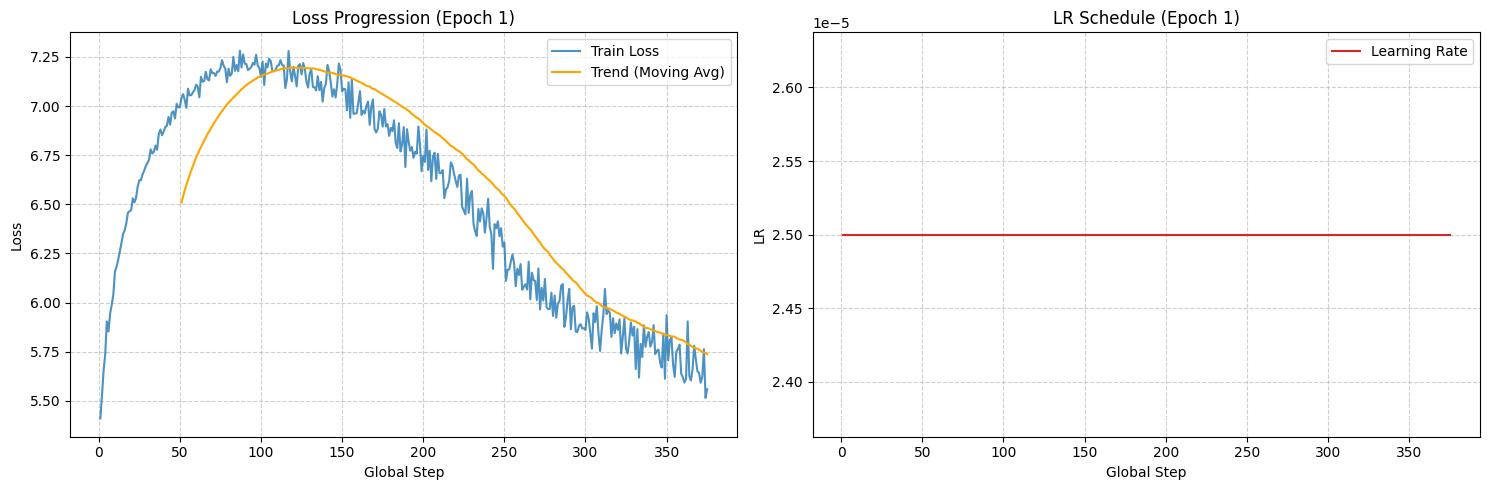

Epoch 2/10:   7%|▋         | 25/375 [00:36<06:22,  1.09s/it, loss=5.6082]

 Step 400 | Loss: 5.6082 | LR: 5.00e-05


Epoch 2/10:  33%|███▎      | 125/375 [02:29<03:30,  1.19it/s, loss=5.1194]

 Step 500 | Loss: 5.1194 | LR: 5.00e-05


Epoch 2/10:  60%|██████    | 225/375 [04:07<02:37,  1.05s/it, loss=4.8401]

 Step 600 | Loss: 4.8401 | LR: 5.00e-05


Epoch 2/10:  87%|████████▋ | 325/375 [05:55<00:34,  1.47it/s, loss=4.6202]

 Step 700 | Loss: 4.6202 | LR: 5.00e-05


Epoch 2/10: 100%|██████████| 375/375 [06:49<00:00,  1.09s/it, loss=4.5407]


[*] Saved Best Model: 4.9745


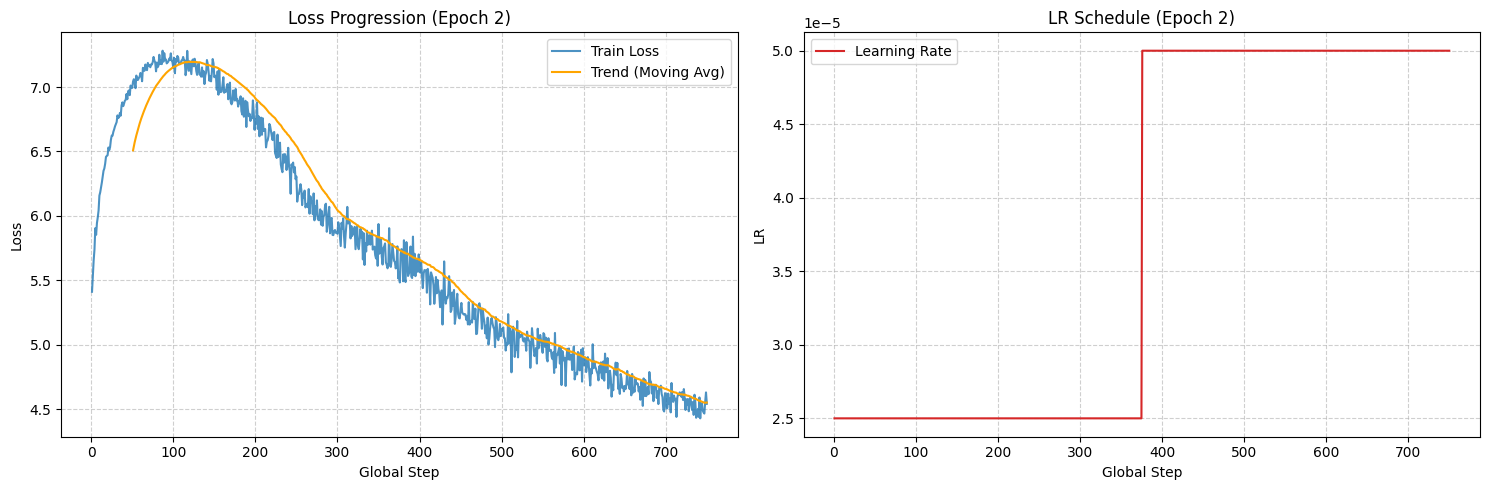

Epoch 3/10:  13%|█▎        | 50/375 [00:56<07:03,  1.30s/it, loss=4.6766]

 Step 800 | Loss: 4.6766 | LR: 4.85e-05


Epoch 3/10:  40%|████      | 150/375 [02:47<04:54,  1.31s/it, loss=4.5593]

 Step 900 | Loss: 4.5593 | LR: 4.85e-05


Epoch 3/10:  67%|██████▋   | 250/375 [04:34<01:45,  1.19it/s, loss=4.3134]

 Step 1000 | Loss: 4.3134 | LR: 4.85e-05


Epoch 3/10:  93%|█████████▎| 350/375 [06:08<00:25,  1.01s/it, loss=3.9960]

 Step 1100 | Loss: 3.9960 | LR: 4.85e-05


Epoch 3/10: 100%|██████████| 375/375 [06:50<00:00,  1.10s/it, loss=3.9642]


[*] Saved Best Model: 4.4233


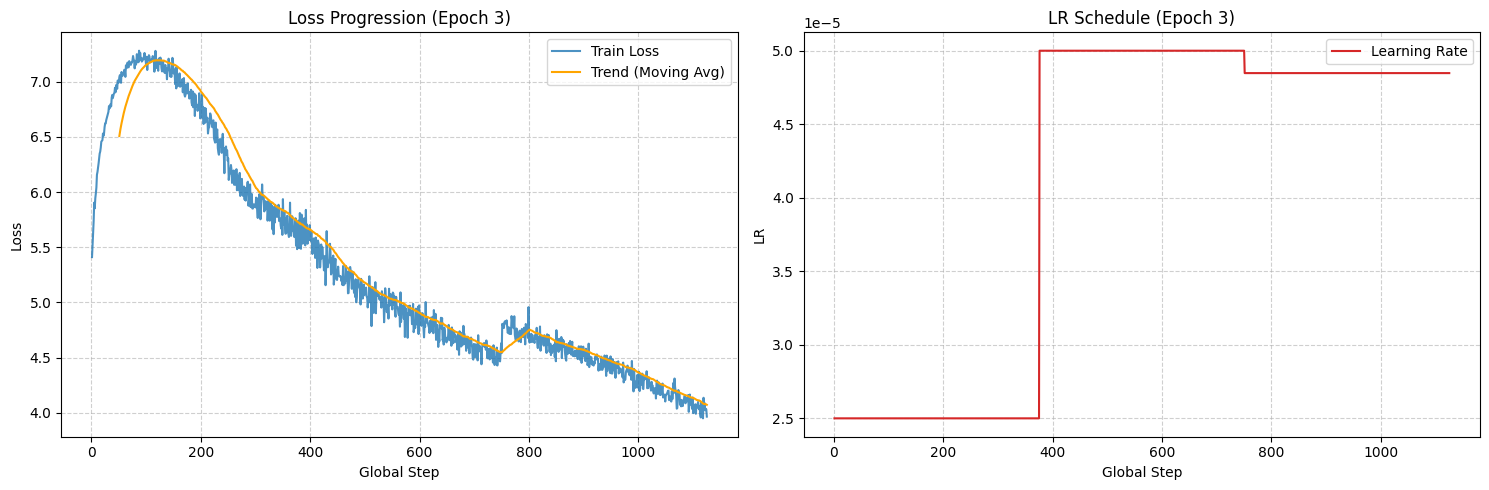

Epoch 4/10:  20%|██        | 75/375 [01:36<03:31,  1.42it/s, loss=3.7703]

 Step 1200 | Loss: 3.7703 | LR: 4.41e-05


Epoch 4/10:  47%|████▋     | 175/375 [03:29<07:01,  2.11s/it, loss=3.5329]

 Step 1300 | Loss: 3.5329 | LR: 4.41e-05


Epoch 4/10:  73%|███████▎  | 275/375 [05:06<01:11,  1.40it/s, loss=3.3006]

 Step 1400 | Loss: 3.3006 | LR: 4.41e-05


Epoch 4/10: 100%|██████████| 375/375 [06:56<00:00,  1.11s/it, loss=2.9520]

 Step 1500 | Loss: 2.9520 | LR: 4.41e-05


[*] Saved Best Model: 3.5157


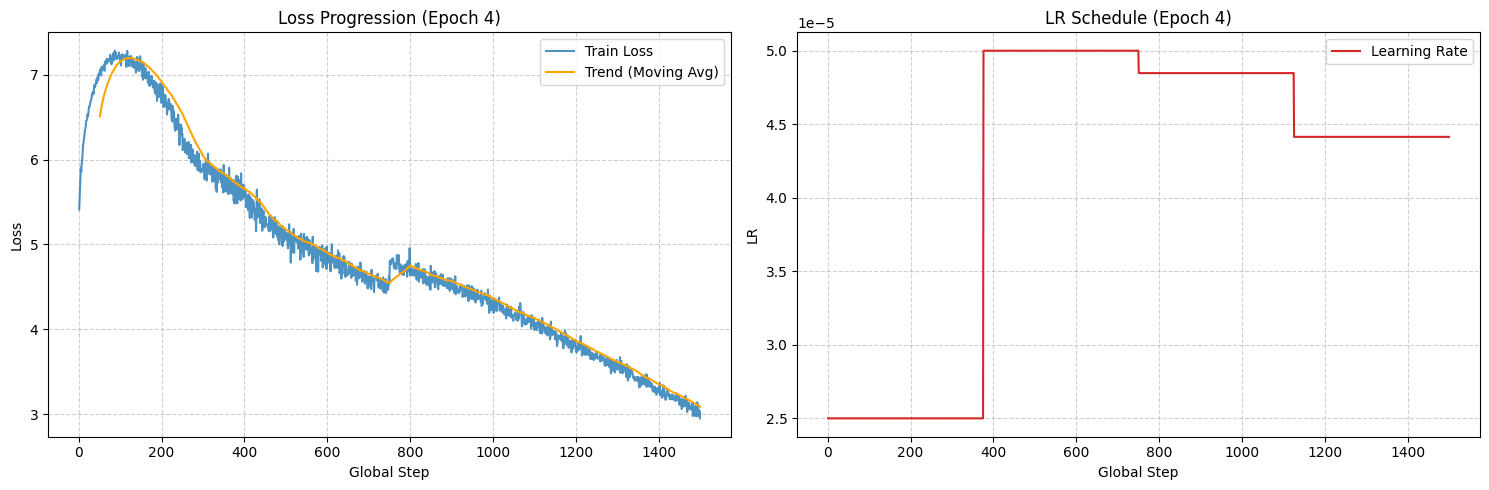

Epoch 5/10:  27%|██▋       | 100/375 [01:52<03:19,  1.38it/s, loss=2.6989]

 Step 1600 | Loss: 2.6989 | LR: 3.77e-05


Epoch 5/10:  53%|█████▎    | 200/375 [03:44<02:30,  1.16it/s, loss=2.4136]

 Step 1700 | Loss: 2.4136 | LR: 3.77e-05


Epoch 5/10:  80%|████████  | 300/375 [05:17<00:53,  1.40it/s, loss=2.1237]

 Step 1800 | Loss: 2.1237 | LR: 3.77e-05


Epoch 5/10: 100%|██████████| 375/375 [06:52<00:00,  1.10s/it, loss=1.9526]


[*] Saved Best Model: 2.4822


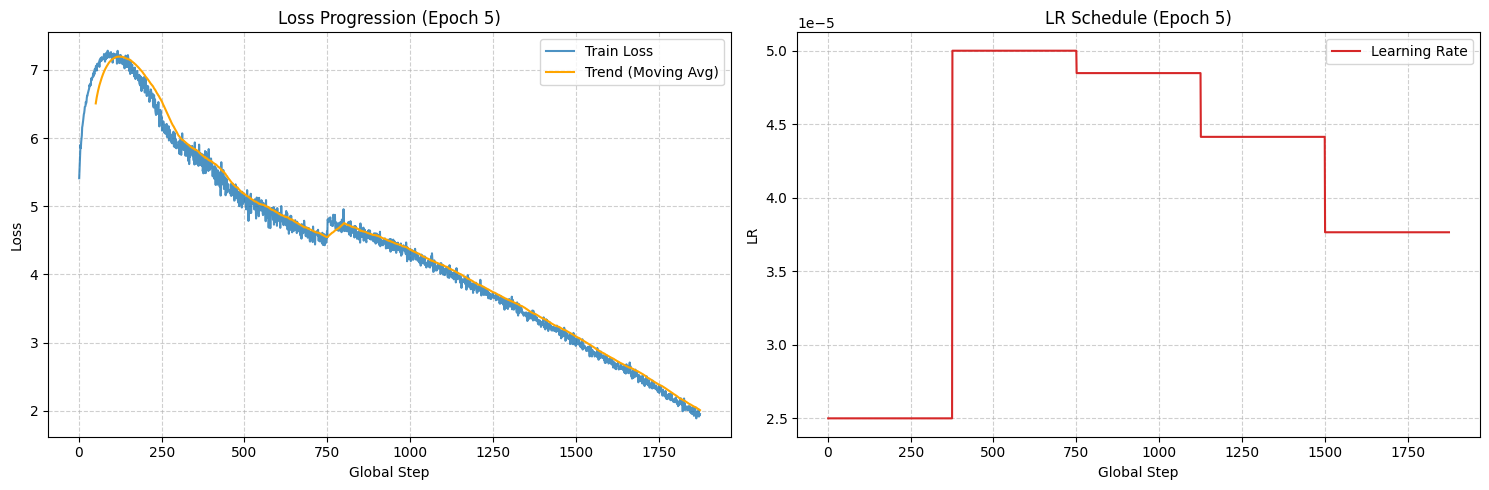

Epoch 6/10:   7%|▋         | 25/375 [00:31<14:57,  2.56s/it, loss=1.9153]

 Step 1900 | Loss: 1.9153 | LR: 3.00e-05


Epoch 6/10:  33%|███▎      | 125/375 [02:36<03:17,  1.27it/s, loss=1.6417]

 Step 2000 | Loss: 1.6417 | LR: 3.00e-05


Epoch 6/10:  60%|██████    | 225/375 [04:21<02:12,  1.13it/s, loss=1.4162]

 Step 2100 | Loss: 1.4162 | LR: 3.00e-05


Epoch 6/10:  87%|████████▋ | 325/375 [05:54<00:50,  1.01s/it, loss=1.1514]

 Step 2200 | Loss: 1.1514 | LR: 3.00e-05


Epoch 6/10: 100%|██████████| 375/375 [06:52<00:00,  1.10s/it, loss=1.1149]


[*] Saved Best Model: 1.5159


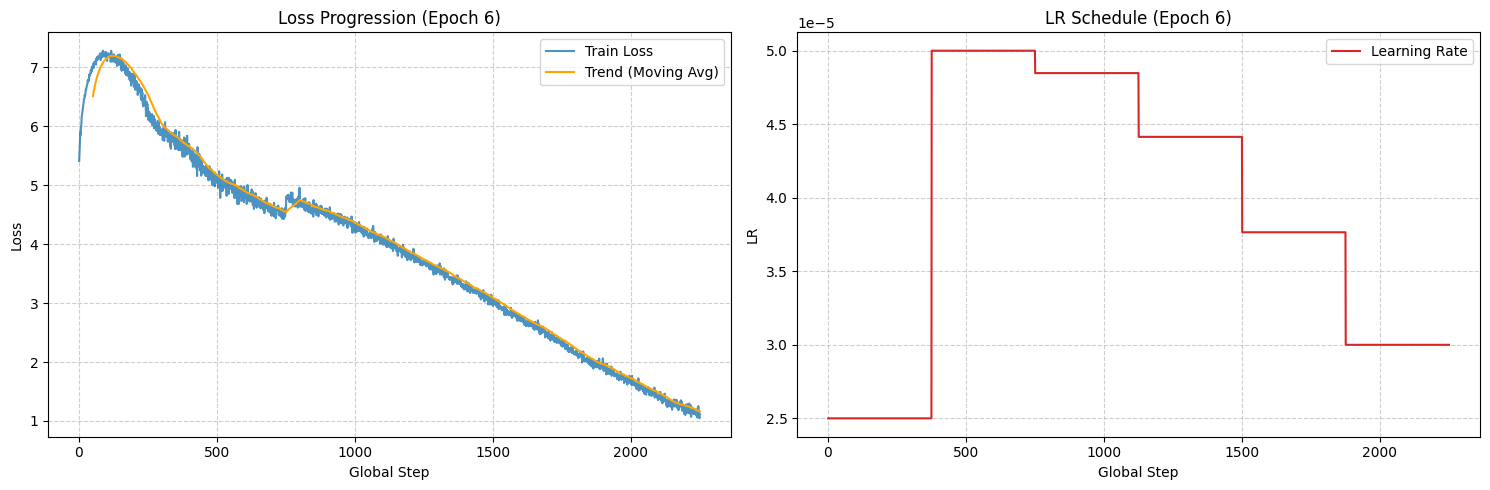

Epoch 7/10:  13%|█▎        | 50/375 [00:57<03:51,  1.41it/s, loss=1.1722]

 Step 2300 | Loss: 1.1722 | LR: 2.23e-05


Epoch 7/10:  40%|████      | 150/375 [02:55<09:28,  2.53s/it, loss=0.9228]

 Step 2400 | Loss: 0.9228 | LR: 2.23e-05


Epoch 7/10:  67%|██████▋   | 250/375 [04:37<03:11,  1.53s/it, loss=0.8015]

 Step 2500 | Loss: 0.8015 | LR: 2.23e-05


Epoch 7/10:  93%|█████████▎| 350/375 [06:26<00:20,  1.23it/s, loss=0.6349]

 Step 2600 | Loss: 0.6349 | LR: 2.23e-05


Epoch 7/10: 100%|██████████| 375/375 [06:50<00:00,  1.10s/it, loss=0.6262]


[*] Saved Best Model: 0.9012


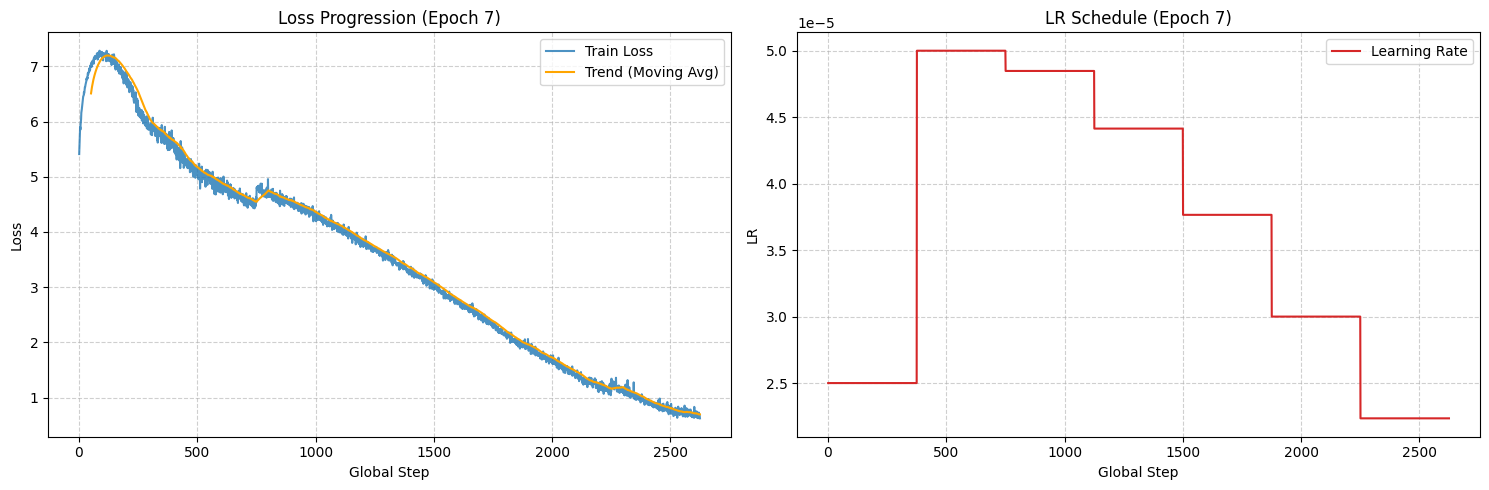

Epoch 8/10:  20%|██        | 75/375 [01:37<06:49,  1.36s/it, loss=0.7703]

 Step 2700 | Loss: 0.7703 | LR: 1.59e-05


Epoch 8/10:  47%|████▋     | 175/375 [03:32<04:05,  1.23s/it, loss=0.6338]

 Step 2800 | Loss: 0.6338 | LR: 1.59e-05


Epoch 8/10:  73%|███████▎  | 275/375 [05:05<01:15,  1.33it/s, loss=0.5290]

 Step 2900 | Loss: 0.5290 | LR: 1.59e-05


Epoch 8/10: 100%|██████████| 375/375 [06:52<00:00,  1.10s/it, loss=0.4630]

 Step 3000 | Loss: 0.4630 | LR: 1.59e-05


[*] Saved Best Model: 0.6036


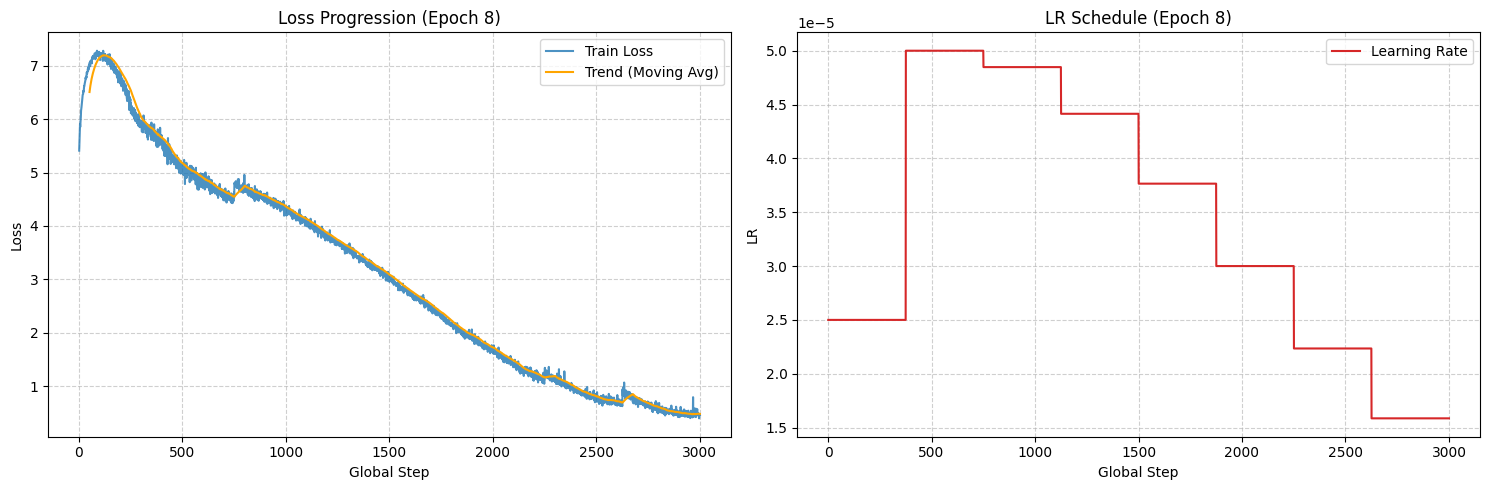

Epoch 9/10:  27%|██▋       | 100/375 [02:01<03:43,  1.23it/s, loss=0.5448]

 Step 3100 | Loss: 0.5448 | LR: 1.15e-05


Epoch 9/10:  53%|█████▎    | 200/375 [03:41<03:02,  1.04s/it, loss=0.3879]

 Step 3200 | Loss: 0.3879 | LR: 1.15e-05


Epoch 9/10:  80%|████████  | 300/375 [05:31<01:24,  1.13s/it, loss=0.3653]

 Step 3300 | Loss: 0.3653 | LR: 1.15e-05


Epoch 9/10: 100%|██████████| 375/375 [06:54<00:00,  1.10s/it, loss=0.3388]


[*] Saved Best Model: 0.4575


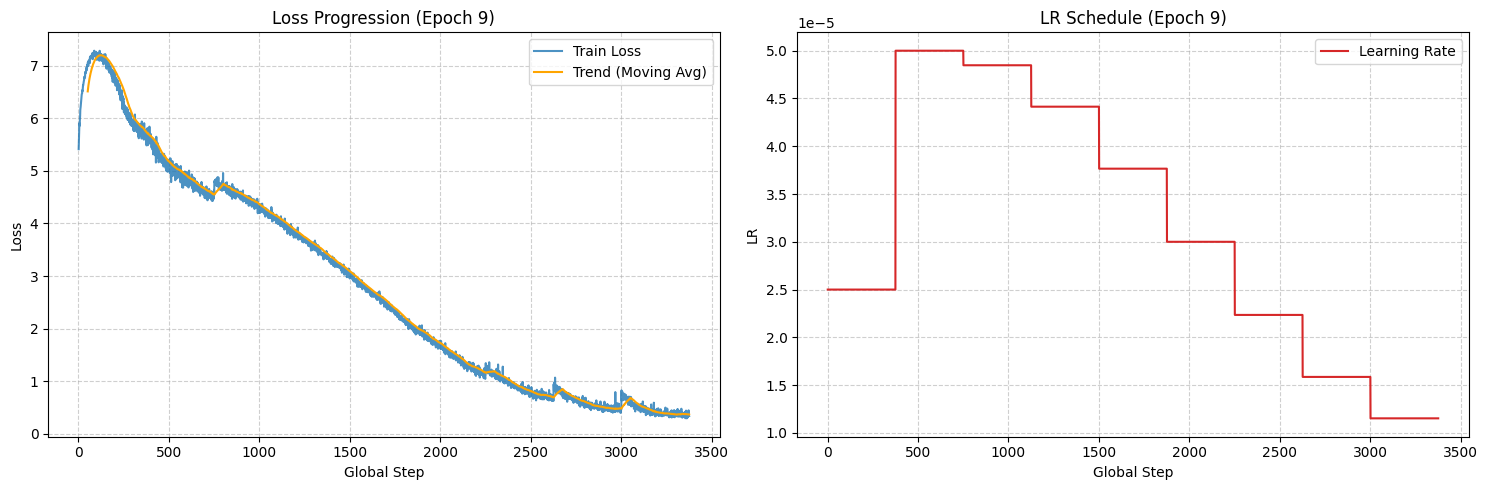

Epoch 10/10:   7%|▋         | 25/375 [00:25<05:31,  1.06it/s, loss=0.4725]

 Step 3400 | Loss: 0.4725 | LR: 1.00e-05


Epoch 10/10:  33%|███▎      | 125/375 [02:22<04:17,  1.03s/it, loss=0.4108]

 Step 3500 | Loss: 0.4108 | LR: 1.00e-05


Epoch 10/10:  60%|██████    | 225/375 [04:10<01:53,  1.33it/s, loss=0.4018]

 Step 3600 | Loss: 0.4018 | LR: 1.00e-05


Epoch 10/10:  87%|████████▋ | 325/375 [06:05<01:12,  1.45s/it, loss=0.4020]

 Step 3700 | Loss: 0.4020 | LR: 1.00e-05


Epoch 10/10: 100%|██████████| 375/375 [06:56<00:00,  1.11s/it, loss=0.3222]


[*] Saved Best Model: 0.3901


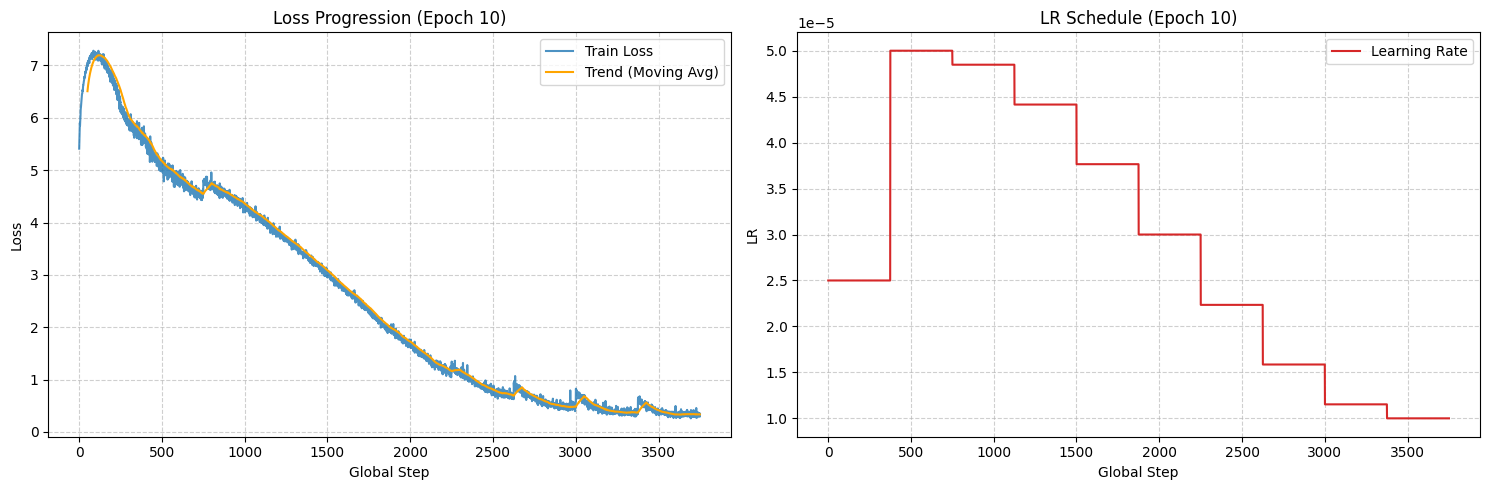

In [22]:
train_with_best_checkpoint(ldmol_dataset, tokenizer_path='/content/drive/MyDrive/LDMol/vocab_bpe_300_sc.txt')

In [23]:
raw_testset = PubChemDataset('/content/drive/MyDrive/LDMol/test.pt')

In [24]:
ldmol_testset = []
for data in raw_testset:
    ldmol_testset.append({
            'smiles': data.smiles,
            'text': data.text
        })

In [25]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import tqdm
import numpy as np

In [26]:
@torch.no_grad()
def evaluate_encoding(ldmol_testset, model_path='/content/drive/MyDrive/LDMol/best_encoder.pt', tokenizer_path='/content/drive/MyDrive/LDMol/vocab_bpe_300_sc.txt'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = regexTokenizer(vocab_path=tokenizer_path, max_len=127)
    model = LDMolEncoder(TRAIN_CONFIG, BERT_CONFIG_DICT).to(device)

    try:
        checkpoint = torch.load(model_path, map_location=device)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        print(f"--- Model successfully loaded from {model_path} ---")
    except Exception as e:
        print(f"--- Loading error: {e} ---")
        return

    model.eval()
    test_ds = SMILESDataset_pretrain(ldmol_testset, shuffle=False, is_train=True)

    loader = DataLoader(test_ds, batch_size=TRAIN_CONFIG['batch_size'], shuffle=False)

    similarities = []

    print("Cosine Similarity Metric")
    for batch_texts in tqdm.tqdm(loader):
        t1, t2 = [], []
        for t in batch_texts:
            parts = t.split('Q')
            if len(parts) == 2:
                t1.append(parts[0])
                t2.append(parts[1])
            else:
                continue

        if not t1: continue

        # Tokenize
        ids1 = tokenizer(t1, truncation='longest').to(device)
        mask1 = torch.where(ids1 == 0, 0, 1)
        ids2 = tokenizer(t2, truncation='longest').to(device)
        mask2 = torch.where(ids2 == 0, 0, 1)
        feat1 = F.normalize(model.text_proj(model.text_encoder(ids1, mask1).last_hidden_state[:, 0, :]), dim=-1)
        feat2 = F.normalize(model.text_proj(model.text_encoder(ids2, mask2).last_hidden_state[:, 0, :]), dim=-1)
        cosine_sim = torch.sum(feat1 * feat2, dim=-1)
        similarities.extend(cosine_sim.cpu().numpy())
    if not similarities:
        print("No data to evaluate.")
        return

    avg_sim = np.mean(similarities)
    print("\n" + "="*30)
    print(f"ENCODING EVALUATION RESULTS:")
    print(f"Averaged Cosine Similarity: {avg_sim:.4f}")
    print(f"Standard Deviation: {np.std(similarities):.4f}")
    print("="*30)

    return similarities

In [27]:
result = evaluate_encoding(ldmol_testset)

--- Model successfully loaded from /content/drive/MyDrive/LDMol/best_encoder.pt ---
Cosine Similarity Metric


100%|██████████| 63/63 [00:42<00:00,  1.49it/s]


ENCODING EVALUATION RESULTS:
Averaged Cosine Similarity: 0.9967
Standard Deviation: 0.0276


In [28]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def sanity_check_model(model, tokenizer, device):
    model.eval()

    # 1. Định nghĩa các cặp kiểm tra
    # Cặp 1: Ethanol (giống nhau nhưng viết khác cách)
    pos_smiles_1 = "[CLS]CCO"
    pos_smiles_2 = "[CLS]C(O)C"

    # Cặp 2: Hai chất khác hẳn nhau (Ethanol vs Benzene)
    neg_smiles_1 = "[CLS]CCO"
    neg_smiles_2 = "[CLS]c1ccccc1"

    def get_embedding(smiles_list):
        ids = tokenizer(smiles_list, truncation='longest').to(device)
        mask = torch.where(ids == 0, 0, 1)
        # Lấy vector đại diện từ Encoder và chiếu qua Projection Head
        out = model.text_encoder(ids, attention_mask=mask).last_hidden_state[:, 0, :]
        feat = F.normalize(model.text_proj(out), dim=-1)
        return feat

    # Tính toán Embedding
    pos_feat = get_embedding([pos_smiles_1, pos_smiles_2])
    neg_feat = get_embedding([neg_smiles_1, neg_smiles_2])

    # Tính Cosine Similarity (Dot product của vector đã normalize)
    sim_positive = torch.dot(pos_feat[0], pos_feat[1]).item()
    sim_negative = torch.dot(neg_feat[0], neg_feat[1]).item()

    print("\n" + "="*40)
    print("KẾT QUẢ KIỂM TRA ĐỐI CHỨNG (SANITY CHECK):")
    print(f"1. Độ tương đồng cặp GIỐNG NHAU (Positive): {sim_positive:.4f}")
    print(f"2. Độ tương đồng cặp KHÁC NHAU  (Negative): {sim_negative:.4f}")
    print("-" * 40)

    # Đưa ra kết luận
    if sim_positive > 0.9 and sim_negative < 0.5:
        print("=> KẾT LUẬN: MÔ HÌNH RẤT TỐT!")
        print("Mô hình phân biệt rõ ràng giữa các phân tử khác nhau.")
    elif sim_positive > 0.9 and sim_negative > 0.8:
        print("=> CẢNH BÁO: FEATURE COLLAPSE!")
        print("Mô hình đang coi mọi thứ đều giống nhau. Bạn cần xem xét lại hàm Loss hoặc nhiệt độ (temp).")
    else:
        print("=> KẾT LUẬN: Mô hình cần huấn luyện thêm hoặc kiểm tra lại dữ liệu.")
    print("="*40)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer_path = '/content/drive/MyDrive/LDMol/vocab_bpe_300_sc.txt'
tokenizer = regexTokenizer(vocab_path=tokenizer_path, max_len=127)
model = LDMolEncoder(TRAIN_CONFIG, BERT_CONFIG_DICT).to(device)
sanity_check_model(model, tokenizer, device)


KẾT QUẢ KIỂM TRA ĐỐI CHỨNG (SANITY CHECK):
1. Độ tương đồng cặp GIỐNG NHAU (Positive): 0.9344
2. Độ tương đồng cặp KHÁC NHAU  (Negative): 0.9488
----------------------------------------
=> CẢNH BÁO: FEATURE COLLAPSE!
Mô hình đang coi mọi thứ đều giống nhau. Bạn cần xem xét lại hàm Loss hoặc nhiệt độ (temp).
